In [1]:
import sys
import os

# Get the path to the project root dynamically
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List
from concurrent.futures import ThreadPoolExecutor, as_completed
from app.models.database import db
from app.services.OptimizeService import OptimizeService
from app.services.PortfolioService import PortfolioService

riskFreeRate = 0.03

# Filter stocks with data for at least 5 years and annual5YrsReturn > riskFreeRate
filtered_stocks = db["stockData"].find({
    "dataCollectedDays": {"$gte": 252 * 5},  # 5 years of trading days
    "annual5YrsReturn": {"$gt": riskFreeRate}  # annual return greater than risk-free rate
})

filtered_stocks = list(filtered_stocks)

print(len(filtered_stocks))

2988


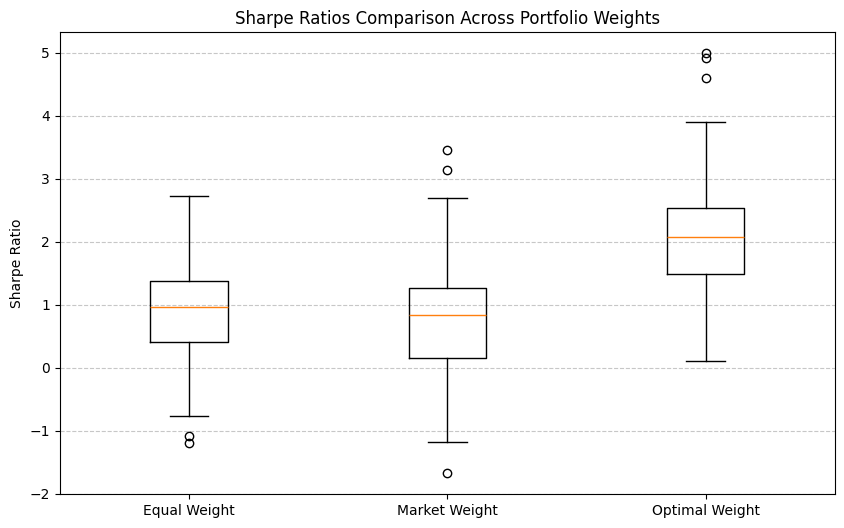

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List
from concurrent.futures import ThreadPoolExecutor, as_completed
from app.models.database import db
from app.services.OptimizeService import OptimizeService
from app.services.PortfolioService import PortfolioService

riskFreeRate = 0.03

portfolioService = PortfolioService()
optimizeService = OptimizeService()

g5_stocks = db["stockData"].find({
    "dataCollectedDays": {"$gte": 252 * 5},  # 5 years of trading days
    "annual5YrsReturn": {"$gt": 0.05}
    })
g5_stocks = list(g5_stocks)

def getStocksPrice(stocks: List[str]):
    df = pd.DataFrame(db["stockHistoryPrice"].find({"symbol": {"$in": stocks}}).sort("date", -1).limit(252 * 5))
    df = df[['date', 'symbol', 'close']].pivot(index='date', columns='symbol', values='close')
    return df

def compute_sharpe_ratios(iteration: int, riskFreeRate: float):
    try:
        # Randomly select the number of stocks (n) and then pick random stocks from g5_stocks
        n = random.randint(3, 10)
        selected_stocks = random.sample(g5_stocks, n)
        stock_symbols = [stock["symbol"] for stock in selected_stocks]
        market_caps = [stock["marketCap"] for stock in selected_stocks]

        # Get stock prices and compute returns and covariance
        df = getStocksPrice(stock_symbols)
        dfReturn = df.pct_change(fill_method=None).dropna()
        returns = (dfReturn.mean() * 252).values
        covMatrix = (dfReturn.cov() * 252).values

        # Calculate portfolio weights
        equalWeight = np.ones(len(stock_symbols)) / len(stock_symbols)
        marketWeight = np.array(market_caps) / np.sum(market_caps)
        optimalWeight = optimizeService.optimizeSharpeRatio(returns, covMatrix, riskFreeRate)

        # Calculate Sharpe Ratios
        optimalSharpeRatio = portfolioService.getPortfolioSharpeRatio(optimalWeight, returns, covMatrix, riskFreeRate)
        equalSharpeRatio = portfolioService.getPortfolioSharpeRatio(equalWeight, returns, covMatrix, riskFreeRate)
        marketSharpeRatio = portfolioService.getPortfolioSharpeRatio(marketWeight, returns, covMatrix, riskFreeRate)

        # Return the results
        return {"Equal": equalSharpeRatio, "Market": marketSharpeRatio, "Optimal": optimalSharpeRatio}
    except Exception as e:
        print(f"Error during iteration {iteration}: {e}")
        return None

# Parameters for testing
iterations = 100  # Number of test iterations
results = {"Equal": [], "Market": [], "Optimal": []}

# Multithreading with ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=50) as executor:
    futures = [executor.submit(compute_sharpe_ratios, i, riskFreeRate) for i in range(iterations)]
    for future in as_completed(futures):
        result = future.result()
        if result:
            results["Equal"].append(result["Equal"])
            results["Market"].append(result["Market"])
            results["Optimal"].append(result["Optimal"])

# Plot the results using a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([results["Equal"], results["Market"], results["Optimal"]],
            tick_labels=["Equal Weight", "Market Weight", "Optimal Weight"])
plt.title("Sharpe Ratios Comparison Across Portfolio Weights")
plt.ylabel("Sharpe Ratio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
